# Machine Learning Project - Suicide Risk Prediction

Suicide is a major global health problem. According to World Health Organization (WHO) [suicide data](https://www.who.int/teams/mental-health-and-substance-use/suicide-data), more than 700,000 people die by suicide every year.

In this project, we'll use machine learning algorithms (decision tree and random forest) to predict suicide risk. We use a dataset on [Kaggle](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016), which contains information from 101 countries such as age group, gender, gross domestic product (GDP) per capita, and human development index (HDI) during the period of 1985 to 2016.

Let's install some required libraries before we begin.

In [2]:
!pip install pandas numpy matplotlib seaborn opendatasets scikit-learn --quiet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import opendatasets as od
import os
%matplotlib inline

In [4]:
# Set some default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# Download the Dataset
Now, we're ready to download the dataset from [Kaggle](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016) using `opendatasets` library.

In [5]:
od.download('https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fooenglow
Your Kaggle Key: ··········


100%|██████████| 397k/397k [00:00<00:00, 68.0MB/s]

The dataset is successfully downloaded and extracted to the directory `suicide-rates-overview-1985-to-2016`. Let's look at the files in the directory.

In [6]:
os.listdir('suicide-rates-overview-1985-to-2016')

['master.csv']

The file `master.csv` contains the data. Let's load it into a Pandas dataframe.

In [7]:
raw_df = pd.read_csv('suicide-rates-overview-1985-to-2016/master.csv')
raw_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


Let's look at the types of data and number of null values under each column.

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


There are leading and trailing spaces in the column name `gdp_for_year ($)`. Let's fix it. 

In [9]:
raw_df.rename(columns={' gdp_for_year ($) ':'gdp_for_year ($)'}, inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

There are 6 numeric columns and 6 categorical columns. The column `HDI for year` contains a lot of missing values. Later, we'll see how we can impute the data or extract the missing information from other sources.

Now, let's try to understand the meaning of some of the "less intuitive" features in the dataset.
* `population`: number of people of the corresponding age group 
* `suicides_no`: number of suicides in the population of a particular age group
*  `HDI for year`: human development index (HDI) of the year. HDI is a composite index measuring average achievement in three basic dimensions of human development — a long and healthy life, knowledge and a decent standard of living.
* `gdp_for_year`: gross domestic product (GDP) of the year. GDP is the total monetary or market value of all the finished goods and services produced within a country's borders. 
* `gdp_per_capita`: a country's GDP divided by its total population


Next, we are going to clean up the data and explore the data to gain some quick insights. 

# Data Cleaning and Manipulation

In this section, let's try to clean up the data and remove/add columns we need for subsequent analysis.

We see earlier that there are a lot of missing values in `HDI for year`. Let's start by manipulating this column.

In [11]:
# Check missing value and drop duplicate rows for the same country and same year
raw_df.loc[raw_df['HDI for year'].isna(), ['country', 'year']].drop_duplicates()

,country,year
0,Albania,1987
12,Albania,1988
24,Albania,1989
36,Albania,1992
48,Albania,1993
...,...,...
27688,Uzbekistan,2001
27700,Uzbekistan,2002
27712,Uzbekistan,2003
27724,Uzbekistan,2004


On the United Nations Development Programme [website](http://hdr.undp.org/en/data), we can access HDI of 190 countries from 1990-2019. I have generated the report in a csv format (`hdi.csv`) from the website. Let's load it into a Pandas dataframe.

In [12]:
hdi_df = pd.read_csv('hdi.csv', index_col='Country')
hdi_df.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.302,0.307,0.316,0.312,0.307,0.331,0.335,0.339,0.344,0.348,0.350,0.353,0.384,0.393,0.409,0.418,0.429,0.447,0.447,0.460,0.472,0.477,0.489,0.496,0.500,0.500,0.502,0.506,0.509,0.511
Albania,0.650,0.631,0.615,0.618,0.624,0.637,0.646,0.645,0.655,0.665,0.671,0.678,0.684,0.691,0.696,0.706,0.713,0.722,0.728,0.733,0.745,0.764,0.775,0.782,0.787,0.788,0.788,0.790,0.792,0.795
Algeria,0.572,0.576,0.582,0.586,0.590,0.595,0.602,0.611,0.621,0.629,0.637,0.647,0.657,0.667,0.677,0.685,0.690,0.700,0.702,0.711,0.721,0.728,0.728,0.729,0.736,0.740,0.743,0.745,0.746,0.748
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.813,0.815,0.820,0.827,0.833,0.827,0.837,0.837,0.840,0.839,0.837,0.836,0.858,0.856,0.863,0.862,0.866,0.863,0.867,0.868
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.391,0.400,0.410,0.426,0.435,0.446,0.460,0.473,0.489,0.501,0.515,0.517,0.533,0.544,0.555,0.565,0.572,0.578,0.582,0.582,0.581


In [13]:
hdi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, Afghanistan to Zimbabwe
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1990    144 non-null    float64
 1   1991    144 non-null    float64
 2   1992    144 non-null    float64
 3   1993    144 non-null    float64
 4   1994    144 non-null    float64
 5   1995    148 non-null    float64
 6   1996    148 non-null    float64
 7   1997    148 non-null    float64
 8   1998    148 non-null    float64
 9   1999    151 non-null    float64
 10  2000    174 non-null    float64
 11  2001    174 non-null    float64
 12  2002    175 non-null    float64
 13  2003    176 non-null    float64
 14  2004    178 non-null    float64
 15  2005    185 non-null    float64
 16  2006    186 non-null    float64
 17  2007    186 non-null    float64
 18  2008    186 non-null    float64
 19  2009    186 non-null    float64
 20  2010    188 non-null    float64
 21  2011    188 non-null    float

Let's try to impute the missing HDI information in `raw_df`
by using the information in `hdi_df`. 

While this might not fully impute the missing values as there are still missing HDI for some countries and years in the `hdi_df`, it should be able to reduce quite a lot of missing HDI in `raw_df`. 

In [14]:
# Iterate over each row in raw_df and impute the missing hdi value if applicable
for row in raw_df.itertuples():
    # Exclude rows with year before 1990 since the earliest hdi available in hdi_df is 1990
    if row.year >= 1990:
        try:
            hdi = hdi_df.loc[row.country, str(row.year)]
            raw_df.at[row.Index, 'HDI for year'] = hdi
        except KeyError:
            pass

Let's check if the number of missing values decreases. 

In [15]:
raw_df.loc[raw_df['HDI for year'].isna(), ['country', 'year']].drop_duplicates()

,country,year
0,Albania,1987
12,Albania,1988
24,Albania,1989
264,Antigua and Barbuda,1985
276,Antigua and Barbuda,1986
...,...,...
27616,Uzbekistan,1995
27628,Uzbekistan,1996
27640,Uzbekistan,1997
27652,Uzbekistan,1998


We can see the number of countries and years with missing HDI has dropped from 1,624 rows to 408 rows. These missing HDI are either before 1990 or not available on the United Nations Programme website.  

From `hdi_df`, we see that HDI generally increases over the years. Since the remaining missing HDI are the values in the earlier years, a reasonable approach would be to impute these missing values using the minimum HDI of each country.

In [16]:
# Group HDI by country and filter the minimum value
min_hdi_df = raw_df[['country', 'HDI for year']].groupby('country').agg({"HDI for year": "min"})
min_hdi_df.head()

,HDI for year
country,
Albania,0.615
Antigua and Barbuda,0.759
Argentina,0.694
Armenia,0.617
Aruba,NaN


In [17]:
# Convert the dataframe to dict
min_hdi_dict = min_hdi_df.to_dict()

# Map missing HDI value according to the input dict
mask = raw_df['HDI for year'].isna()
raw_df.loc[mask, 'HDI for year'] = raw_df.loc[mask, 'country'].apply(lambda x: min_hdi_dict['HDI for year'][x])

We have pretty much imputed most of the missing HDI. For the remaining missing values, let's impute using average HDI across the countries of each year. 

In [18]:
# Compute a pandas series with mean hdi of each year
mean_hdi = hdi_df.mean()

# Create bool mask for rows with missing HDI (before 1990 and on/after 1990)
mask_bf_1990 = (raw_df['HDI for year'].isna()) & (raw_df['year'] < 1990)
mask_aft_1990 = (raw_df['HDI for year'].isna()) & (raw_df['year'] >= 1990)

# Impute missing HDI using average HDI (on/after 1990). If missing HDI is before 1990, impute using average HDI of 1990
raw_df.loc[mask_aft_1990, 'HDI for year'] = raw_df.loc[mask_aft_1990, 'year'].apply(lambda x: mean_hdi[str(x)])
raw_df.loc[mask_bf_1990, 'HDI for year'] = mean_hdi['1990']

In [19]:
raw_df['HDI for year'].isna().sum()

0

Great! We've sufficiently addressed all the missing HDI. Now, let's also drop the column `country-year` since the information is already available under columns `country` and `year`.

In [20]:
raw_df.drop(columns=['country-year'], inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

# Exploratory Data Analysis

Let's explore and visualize the dataset to get some useful insights before training our machine learning models.

## Suicide Incidence Across the Countries

First, we'll visualize the suicide rate across the countries on a map using `geopandas` library.

In [22]:
!pip install geopandas --quiet

# Reference: https://geopandas.org/docs/user_guide/mapping.html
import geopandas

     |████████████████████████████████| 994 kB 2.6 MB/s 
     |████████████████████████████████| 6.3 MB 38.2 MB/s 
     |████████████████████████████████| 15.4 MB 35 kB/s 


In [25]:
# Load the map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Now, let's group the suicide data by country and calculate the aggregated number of suicides per 100k population for each country.

In [26]:
# Group the data by country and find the sum of suicides number and population
suicide_by_country_df = raw_df.groupby('country')[['suicides_no', 'population']].sum().reset_index()

# Calculate suicides/100k pop
suicide_by_country_df['suicides/100k pop'] = 100000 * suicide_by_country_df['suicides_no'] / suicide_by_country_df['population']

# Sort the rows by suicides/100k pop from highest to lowest
suicide_by_country_df.sort_values(by='suicides/100k pop', ascending=False, inplace=True)
suicide_by_country_df.head()

,country,suicides_no,population,suicides/100k pop
52,Lithuania,28039,68085210,41.182219
75,Russian Federation,1209742,3690802620,32.777207
87,Sri Lanka,55641,182525626,30.483939
11,Belarus,59892,197372292,30.344685
40,Hungary,73891,248644256,29.717558


We can merge `world` and `suicide_by_country_df` to plot the suicide incidence of each country. Before that, we need to modify some country names in `world` as there are discrepancies between the two dataframes. 

In [27]:
# Modify country name due to a difference in two dataframes
country_match = {'Russia': 'Russian Federation', 'United States of America': 'United States', 'South Korea': 'Republic of Korea', 
                 'Bosnia and Herz.': 'Bosnia and Herzegovina'}
world['name'].replace(country_match, inplace=True)

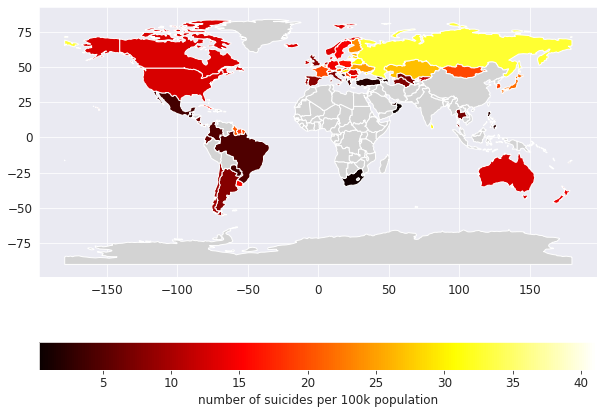

In [28]:
# Merge the two dataframes together
table = world.merge(suicide_by_country_df, how='left', left_on=['name'], right_on=['country'])

# Create the map
table.plot(column='suicides/100k pop', 
           cmap='hot',
           legend=True, 
           legend_kwds={'label': 'number of suicides per 100k population',
                        'orientation': 'horizontal'},
           missing_kwds={'color': 'lightgrey'});

From the map, the suicide incidence is higher in Russian Federation and some European countries, compared to Australia and America.

We can also see that we do not have suicide data for most of the Asia and Africa countries, and our machine learning model will not generalize well to these countries.

## Suicide Over Time

Let's take a look at the suicide incidence over the past 20 years.

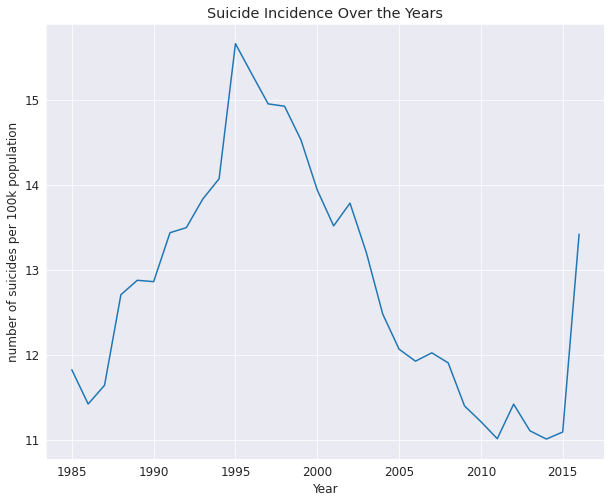

In [29]:
# x-axis from year 1985 to 2016
x = np.arange(1985, 2017)

# y-axis is the mean suicide no. per 100k population
y = raw_df.groupby('year')['suicides/100k pop'].mean()

# Create a line plot
sns.lineplot(x=x, y=y)
plt.xlabel('Year')
plt.ylabel('number of suicides per 100k population')
plt.title('Suicide Incidence Over the Years');

The suicide incidence of the countries in our dataset peaked in 1995 and followed a downtrend since then. However, in 2015, there was a sudden surge of number of suicides. 

## Age and Gender Distribution of People Committing Suicide

Let's visualize the number of suicides by age and gender.

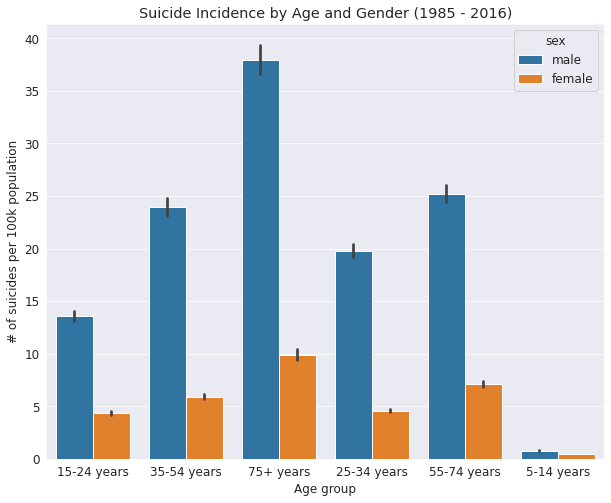

In [30]:
# Create a barplot 
sns.barplot(data=raw_df, x='age', y='suicides/100k pop', hue='sex')
plt.xlabel('Age group')
plt.ylabel('# of suicides per 100k population')
plt.title('Suicide Incidence by Age and Gender (1985 - 2016)');

Older adults have a higher tendency of committing suicide. This might be related to factors such as loneliness, social connectedness, chronic diseases, etc. *(further reading [here](https://www.sprc.org/populations/older-adults))*.

Across all age groups, suicide occurred almost 3-4 times more often in males than females. This could be because male suicide methods are often more violent, making them more likely to be completed before anyone can intervene. There might also be social stigma that men cannot be weak, which causes them not to share their struggles openly. *(further reading [here](https://www.bbc.com/future/article/20190313-why-more-men-kill-themselves-than-women))*.

## Numeric Variables Correlated with Suicide

After exploring the relationship between categorical variables and suicide, let's see the correlation between numeric variables and suicide. We can visualize the relationship using a heatmap.

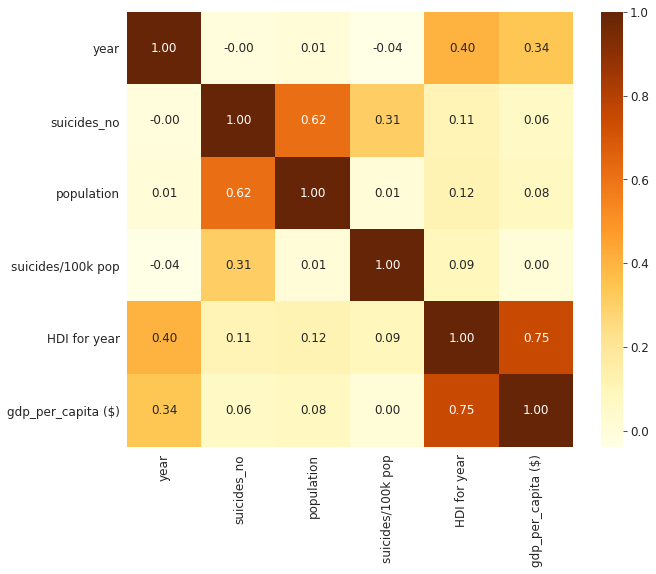

In [31]:
sns.heatmap(raw_df.corr(), annot=True, cmap='YlOrBr', fmt='.2f');

There doesn't seem to be strong relationship between numerical variables and suicide. The correlation coefficient between `population` and `suicides_no` is quite high (0.62), but actually there is no "real" correlation (coefficient = 0.01) after normalizing the number of suicides by population.

We've completed the EDA. 

# Prepare the Data for Training

We'll follow the general steps below (where applicable) to prepare dataset for training.
* Create the target column
* Create a train/validation/test split
* Identify input and target columns
* Identify numeric and categorical columns
* Impute missing numeric values
* Scale numeric values 
* Encode categorical columns

## Create the target column

Before we split the dataset into train/validation/test set, let's create our target column `suicide_risk` (i.e. high / low risk) using the information from `suicides/100k pop`. 

If the value of `suicides/100k pop` is higher than the mean of `suicides/100k pop`, we will classify the suicide risk as high, and low otherwise. 

In [33]:
# Create additional column for suicide risk and set the default value as low
raw_df['suicide_risk'] = 'low' 

# Set the risk as high if suicides/100k pop is higher than the mean
raw_df.loc[raw_df['suicides/100k pop'] > raw_df['suicides/100k pop'].mean(), 'suicide_risk'] = 'high' 
raw_df['suicide_risk'].value_counts()

low     19061
high     8759
Name: suicide_risk, dtype: int64

## Create Train, Validation and Test Sets

Let's split our dataset into three parts.

1.   Train set: used to train a model
2.   Validation set: used to tune model hyperparameters (e.g., regularization parameter) and choose between models during training
3.   Test set: used to compare different models and report the model's final accuracy

In general, we can pick random subset of rows to create train/validation/test set in a distribution of 60-20-20 rule. However, when working with time-series data, it's better to split the dataset based on time, so the model was trained using the data in the past, and evaluated using the data in the future.

Let's look at the distribution fo our data by `year`.

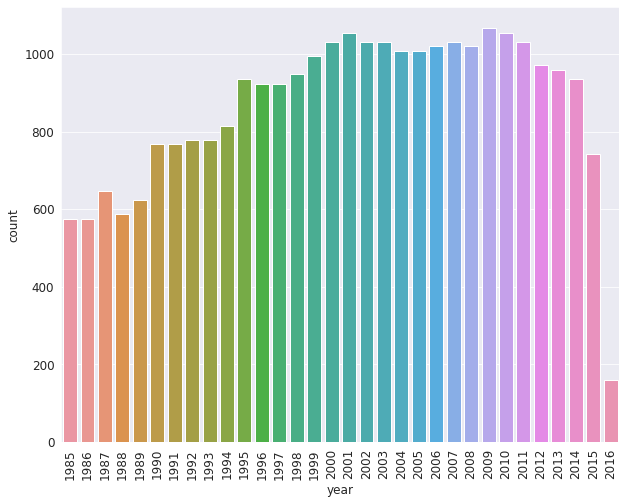

In [34]:
sns.countplot(x='year', data=raw_df)
plt.xticks(rotation='90');

It's a bit challenging to decide which year we should use as a split point by looking at the count. Let's look at the cumulative percentage instead.

In [35]:
# Create a series containing number of data per year
year_dt = raw_df.year.value_counts()
year_dt.sort_index(inplace=True)
cum_pct = 100 * year_dt.cumsum() / year_dt.sum()
cum_pct

1985      2.070453
1986      4.140906
1987      6.470165
1988      8.583753
1989     10.826743
1990     13.587347
1991     16.347951
1992     19.151689
1993     21.955428
1994     24.888569
1995     28.253055
1996     31.574407
1997     34.895758
1998     38.303379
1999     41.883537
2000     45.593098
2001     49.388929
2002     53.098490
2003     56.808052
2004     60.431344
2005     64.054637
2006     67.721064
2007     71.430625
2008     75.097052
2009     78.936017
2010     82.731848
2011     86.441409
2012     89.935298
2013     93.386053
2014     96.750539
2015     99.424874
2016    100.000000
Name: year, dtype: float64

Approximately 60% of data are before 2004 (cumulative percentage = 60.4%), and 20% of data are between 2005 and 2010 (cumulative percentage = 82.7%).

Let's split the data into train/validation/test set using year 2004 and year 2010 as breakpoint.

In [36]:
train_df = raw_df.loc[raw_df['year'] <= 2004]
val_df = raw_df.loc[(raw_df['year'] >= 2005) & (raw_df['year'] <=2010)]
test_df = raw_df.loc[raw_df['year'] >= 2011]

print('train_df.shape: ', train_df.shape)
print('val_df.shape: ', val_df.shape)
print('test_df.shape: ', test_df.shape)

train_df.shape:  (16812, 12)
val_df.shape:  (6204, 12)
test_df.shape:  (4804, 12)


## Identify Input and Target Columns

Often, not all the columns in the dataset are useful for training a model. We will ignore the following columns:

*   `year`: this is not relevant as we are predicting the suicide risk of a particular person in the future
*   `suicides_no`, `population`: contains redundant information as `suicides/100k pop`
*   `suicides/100k pop`: contains redundant information as `suicide_risk`
*   `gdp_for_year ($)`: contains redundant information as `gdp_per_capita ($)`
*   `generation`: contains redundant information as  `age`. Each generation is corresponding to a specific age group under `age`.


In [37]:
input_cols = ['country', 'sex', 'age', 'HDI for year', 'gdp_per_capita ($)']
target_col = 'suicide_risk'

In [42]:
train_inputs = train_df.loc[:, input_cols]
train_target = train_df.loc[:, target_col]

val_inputs = val_df.loc[:, input_cols]
val_target = val_df.loc[:, target_col]

test_inputs = test_df.loc[:, input_cols]
test_target = test_df.loc[:, target_col]

Let's also identify the numeric and categorical columns.

In [43]:
numeric_cols = list(train_inputs.select_dtypes(include=np.number).columns)
categorical_cols = list(train_inputs.select_dtypes(include='object').columns)

print('numeric columns: ', numeric_cols)
print('categorical columns: ', categorical_cols)

numeric columns:  ['HDI for year', 'gdp_per_capita ($)']
categorical columns:  ['country', 'sex', 'age']


We'll skip the step of missing value imputation as we have handled the missing values of `HDI for year` before performing exploratory data analysis. There is no null data in other columns.

## Scale Numeric Features

Let's scale the numeric features (i.e., `HDI for year`, `gdp_per_capita`) to a range of value of 0 to 1. This ensures that no particular numeric features has a disproportionate impact on the model's loss. It also smoothens the training process.

Let's use `MinMaxScaler` from `sklearn.preprocessing` to scale values to (0,1) range.

*Refer [here](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/) for difference between normalization and standardization.*

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Fit the scaler to all the data
scaler = MinMaxScaler().fit(raw_df.loc[:, numeric_cols])

# Scale the train, validation and test sets 
train_inputs.loc[:, numeric_cols] = scaler.transform(train_inputs.loc[:, numeric_cols])
val_inputs.loc[:, numeric_cols] = scaler.transform(val_inputs.loc[:, numeric_cols])
test_inputs.loc[:, numeric_cols] = scaler.transform(test_inputs.loc[:, numeric_cols])

In [41]:
train_inputs[numeric_cols].describe()

,HDI for year,gdp_per_capita ($)
count,16812.000000,16812.000000
mean,0.543938,0.091012
std,0.198714,0.098749
min,0.000000,0.000000
25%,0.399142,0.016384
50%,0.536481,0.042918
75%,0.695279,0.153068
max,0.967811,0.637489


## Encode categorical columns

To train the machine learning models, we need to transform the values of categorical columns into numbers. There are different ways to encode the data, such as label encoding and one-hot encoding. 

Here, we will use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) from `sklearn.preprocessing`. What it does is to convert each category value into a new column and assign a `1` or `0` (True/False) value to the column. This has the benefit of not weighting a value improperly.

In [45]:
# Check the number of unique values of each categorical column
raw_df[categorical_cols].nunique()

country    101
sex          2
age          6
dtype: int64

In [46]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore').fit(raw_df[categorical_cols])

Let's generate column names for each individual category using `get_feature_names` and add all the columns to `train_inputs`, `val_inputs`, and `test_inputs`. 

In [47]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

# Encode the columns
train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
val_inputs[encoded_cols] = encoder.transform(val_inputs.loc[:, categorical_cols]).toarray()
test_inputs[encoded_cols] = encoder.transform(test_inputs.loc[:, categorical_cols]).toarray()

As a final step, let's drop the textual categorical columns, so that we're left with just numerical data.

In [48]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Decision Tree

Let's train a decision tree classifier to classify the suicide risk into high or low based on the input data.

In [50]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, train_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

## Evaluation

The decision tree has been trained. Let's evaluate its performance using the accuracy score.

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_pred = tree.predict(X_train)
accuracy_score(train_target, train_pred)

1.0

The training accuracy is 100%. Let's evaluate the model using the validation set.

In [52]:
val_pred = tree.predict(X_val)
accuracy_score(val_target, val_pred)

0.8813668600902643

The validation set accuracy is about 88%, which is better than always predicting "low".

In [53]:
val_target.value_counts() / len(val_target)

low     0.705029
high    0.294971
Name: suicide_risk, dtype: float64

## Visualization

Let's also visualize the first few layers of the decision tree. 

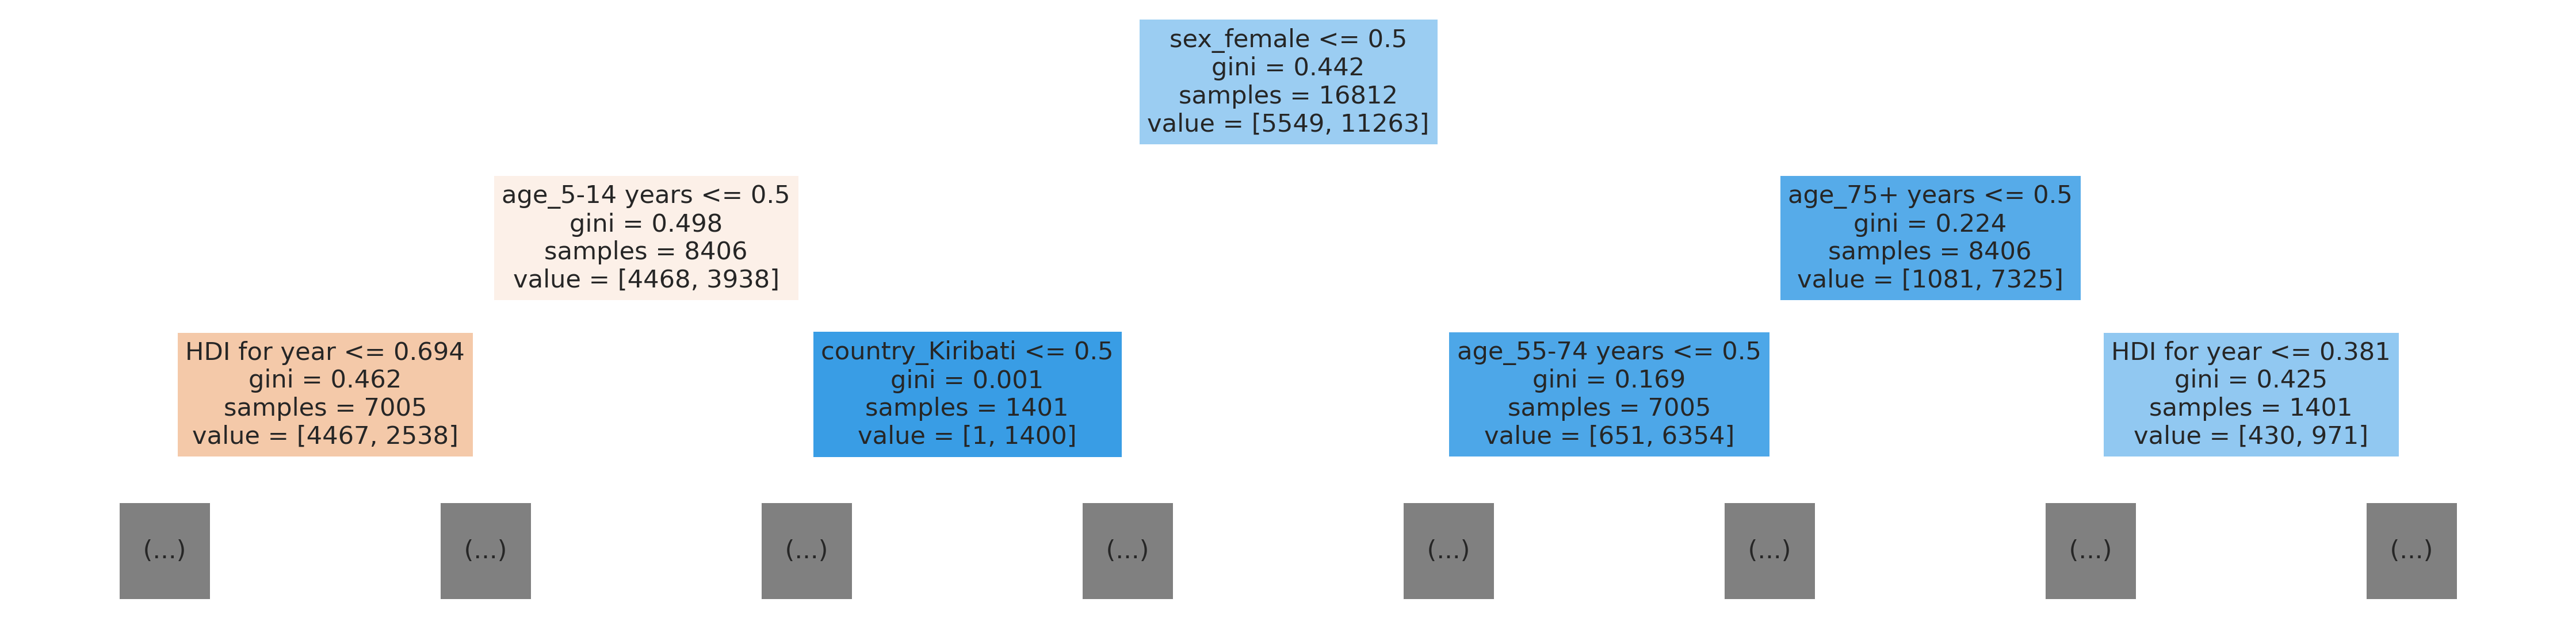

In [54]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 20))
plot_tree(tree, feature_names=X_train.columns, max_depth=2, filled=True);

We can see that the model classifies the input data by a series of decisions. If a split results in information gain (measured by Gini Impurity Index - a lower Gini Index indicates a better split), the split will happen.

In our decision tree model, the input data was first split by sex, followed by age group, HDI for year, and country. 

## Feature Importance

Based on the Gini index computation, each feature is assigned a "Gini importance", which is computed as the (normalized) total reduction of Gini index brought by that feature. Let's see which feature is more important to predict the suicide risk. 



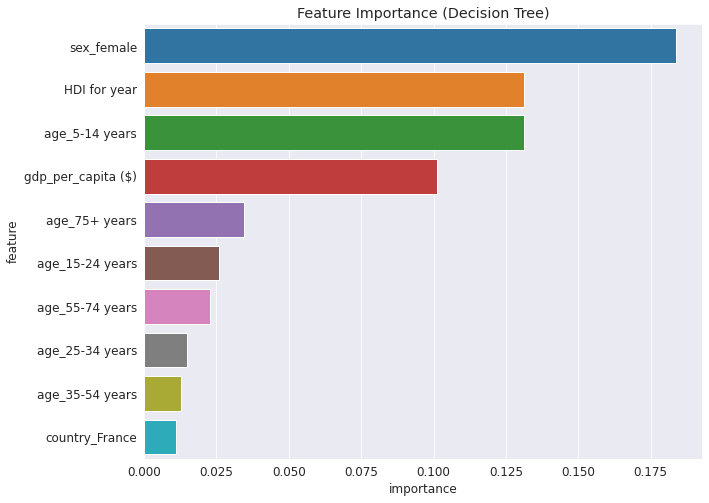

In [55]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree.feature_importances_
}).sort_values(by='importance', ascending=False)

# Visualize the feature importance
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importance (Decision Tree)');

The most important feature to predict the suicide risk is `sex_female` (0.18), followed by `HDI for year` and `age_5-14 years`, which both have similar importance of around 0.13. Other important features include `gdp_per_capita` and other age groups.

## Hyperparameter Tuning

Next, let's tune some hyperparameters to see if we can improve the accuracy of the model on the validation set.

One common problem of decision tree is that it tends to overfit the training data. In our case, the training accuracy is 100%, which basically means that the model has memorized all the train data (=overfitting). In order to make the model generalize better to unseen data, let's try to tune two hyperparameters.

1.   `max_depth`: controls the overall complexity of a decision tree (adequate assuming that the tree built is symmetric)
2.   `min_samples_split`: minimum number of samples required to split an internal node



### Max Depth Tuning

If a tree is too deep, it will overfit training data. Let's explore the max depth to optimize the bias-variance trade off, so we do not create partitions which are for "noisy" data (outlier) in the training dataset.

Let's first take a look at the `max_depth` of the current decision tree.

In [56]:
tree.tree_.max_depth

42

Let's experiment with different `max_depth` using a helper function `max_depth_tuning`. We'll test the `max_depth` for a range from 2 to 42, with a step of 2.

In [57]:
def max_depth_tuning(md):
    tree = DecisionTreeClassifier(random_state=1, max_depth=md)
    tree.fit(X_train, train_target)
    train_pred = tree.predict(X_train)
    val_pred = tree.predict(X_val)
    train_error = 1 - accuracy_score(train_target, train_pred)
    val_error = 1 - accuracy_score(val_target, val_pred)
    return {'max_depth': md, 'train_error': train_error, 'val_error': val_error}

In [58]:
# Create a dataframe to store the tuning result
errors_df = pd.DataFrame([max_depth_tuning(md) for md in range(2, 43, 2)])

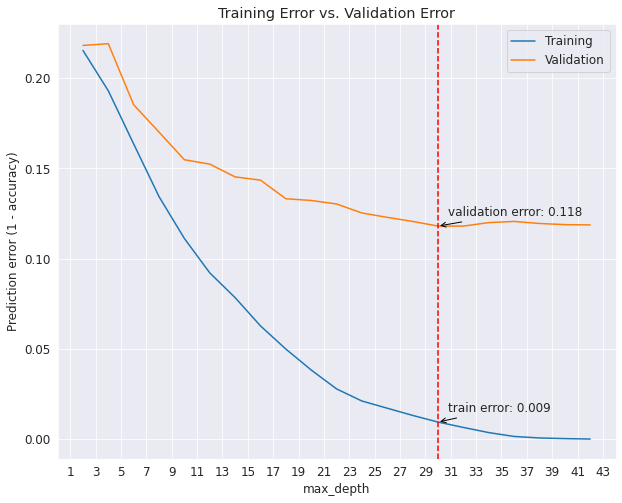

In [59]:
# Create a line plot to visualize training error and validation error against max_depth
fig, ax = plt.subplots()
sns.lineplot(data=errors_df, x='max_depth', y='train_error', ax=ax)
sns.lineplot(data=errors_df, x='max_depth', y='val_error', ax=ax)
plt.ylabel('Prediction error (1 - accuracy)')
plt.xticks(range(1, 44, 2))
plt.title('Training Error vs. Validation Error')
plt.legend(['Training', 'Validation'])

# Annotate the training error and validation error 
plt.axvline(x=30, color='r', linestyle='--')
ax.annotate('validation error: 0.118',
            xy=(30, 0.117988),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"))
ax.annotate('train error: 0.009',
            xy=(30, 0.009398),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"))
plt.show()

Both training error and validation error shows a decreasing trend with the increase of `max_depth`. It is not so obvious from the graph, but the validation error is the lowest when the `max_depth` is around 30. Beyond `max_depth` of 30, the validation error increases slightly. 

### Best Combination of Max Depth and Min Samples Split

We've explored the range of max depth values earlier and identified max_depth of 30 to be the optimal value. Now, let's include another hyperparameter `min_samples_split` in the tuning process. `Min_samples_split` is the minimum number of samples required to split an internal node. For example, if we specify the `min_samples_split` as 2, the split resulting in a leaf with 1 sample will not be allowed. Too high a `min_samples_split` value can lead to underfitting.

Here, we'll use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function from `sklearn.model_selection`. It can help us find the optimal combination of the specified hyperparameters which gives the best prediction. Let's first specify the type and range of hyperparameters we would like to test.


In [60]:
param_dict = {
    "max_depth": range(2, 40, 2),
    "min_samples_split": range(2, 10, 2)
}

Before we proceed further, there is one point we need to take note of. When using `GridSearchCV` function, it handles the split of dataset into train/validation set and performs 5-fold cross validation splitting strategy by default. It is possible to explicitly specify the train/validation set ([reference](https://stackoverflow.com/questions/48390601/explicitly-specifying-test-train-sets-in-gridsearchcv)), but it will be more tedious. 

Here, we choose to let `GridSearchCV` to handle the split. So, let's combine the train set and validation set before running the function.

In [61]:
X = pd.concat([X_train, X_val])
Y = pd.concat([train_target, val_target])
print(X.shape, Y.shape)

(23016, 111) (23016,)


In [62]:
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(random_state=1)
grid = GridSearchCV(tree, param_grid=param_dict)
grid.fit(X, Y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(2, 40, 2),
                         'min_samples_split': range(2, 10, 2)},
     

Let's look at the best combination of hyperparameters and the accuracy score. 

In [63]:
print('best params: ', grid.best_params_)
print('accuracy score: ', grid.best_score_)

best params:  {'max_depth': 34, 'min_samples_split': 2}
accuracy score:  0.8560991839832482


The optimal hyperparameter combination is `max_depth` of 34 and `min_samples_split` of 2. Let's evaluate the performance of this model on test set.

In [64]:
test_pred = grid.predict(X_test)
accuracy_score(test_target, test_pred)

0.9094504579517069

The test set accuracy score is pretty good at about 91%! Let's save our model (including weights, hyperparameters) so we do not need to retrain the model from scratch every time we need to use it. Along with the model, we also save the important elements such as encoder, scaler, and column names.

## Save Trained Model

We can use `joblib` [module](https://joblib.readthedocs.io/en/latest/) to save and load Python objects on the disk.

In [65]:
import joblib

In [66]:
suicide_risk_dt = {
    'model': grid,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [67]:
joblib.dump(suicide_risk_dt, 'suicide_risk_dt.joblib')

['suicide_risk_dt.joblib']

## Make Prediction on New Inputs

Let's load our decision tree model back using `joblib.load`. 

In [68]:
suicide_risk_dt_clf = joblib.load('suicide_risk_dt.joblib')

We can define a helper function to make predictions on new inputs.

In [69]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[model['numeric_cols']] = model['scaler'].transform(input_df[model['numeric_cols']])
    input_df[model['encoded_cols']] = model['encoder'].transform(input_df[model['categorical_cols']]).toarray()
    X_input = input_df[model['numeric_cols'] + model['encoded_cols']]
    pred = model['model'].predict(X_input)[0]
    prob = model['model'].predict_proba(X_input)[0][list(model['model'].classes_).index(pred)]
    return pred, prob

In [70]:
new_input = {
    'country': 'Republic of Korea',
    'year': 2020,
    'sex': 'male',
    'age': '75+ years',
    'suicides_no': 1400,
    'population': 900000,
    'suicides/100k pop': 155.55,
    'HDI for year': 0.9,
    'gdp_for_year ($)': '1,000,000,000',
    'gdp_per_capita ($)': 29000,
    'generation': 'Silent' 
}

In [71]:
predict_input(suicide_risk_dt_clf, new_input)

('high', 1.0)

Let's modify some important predictors of suicide risk (e.g., `sex_female`, `HDI for year`) and see if the prediction changes. 

In [72]:
new_input_2 = {
    'country': 'Singapore',
    'year': 2020,
    'sex': 'female',
    'age': '15-24 years',
    'suicides_no': 14,
    'population': 250000,
    'suicides/100k pop': 5.6,
    'HDI for year': 0.7,
    'gdp_for_year ($)': '300,000,000,000',
    'gdp_per_capita ($)': 80000,
    'generation': 'Millenials' 
}

In [73]:
predict_input(suicide_risk_dt_clf, new_input_2)

('low', 1.0)

# Random Forest

Next, let's train a random forest model using the same train/validation/test dataset. Random forest trains several decision trees based on randomly selected data samples, gets predictions from each tree and makes the best prediction by means of voting.

In general, a random forest model is highly robust and can reduce overfitting as the final prediction was made by averaging the predictions from multiple decision trees. The drawback is the speed because all the trees in the forest need to make a prediction before voting.

We'll use `RandomForestClassifier` from `sklearn.ensemble`.

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=1)
rf.fit(X_train, train_target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

## Evaluation

Let's look at the training accuracy and validation accuracy.

In [76]:
train_pred = rf.predict(X_train)
print('training accuracy: ', accuracy_score(train_target, train_pred))

val_pred = rf.predict(X_val)
print('validation accuracy: ', accuracy_score(val_target, val_pred))

training accuracy:  0.9999405186771354
validation accuracy:  0.902321083172147


The performance of the random forest model is actually pretty good. When using decision tree model earlier, our validation accuracy is around 85-89% with different tuning. Let's check the feature importance and see if it is comparable with the important features identifed from our single decision tree model. 

## Feature Importance

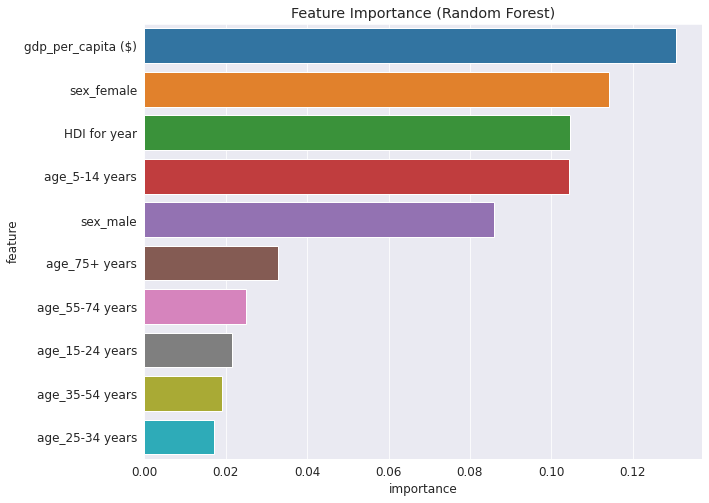

In [77]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Visualize the feature importance
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importance (Random Forest)');

`gdp_per_capita ($)` turns out to be the most important feature in random forest model (4th important feature in decision tree model). The other important features (e.g., `sex_female`, `HDI for year`, `age_5-14 years`) are largely similar to the results from decision tree model.

## Visualization

Let's take a look at a few decision trees from the random forest. The decision trees can be accessed via `estimators_` attribute.

In [78]:
len(rf.estimators_)

100

Currently, we have 100 decision trees in the forest.

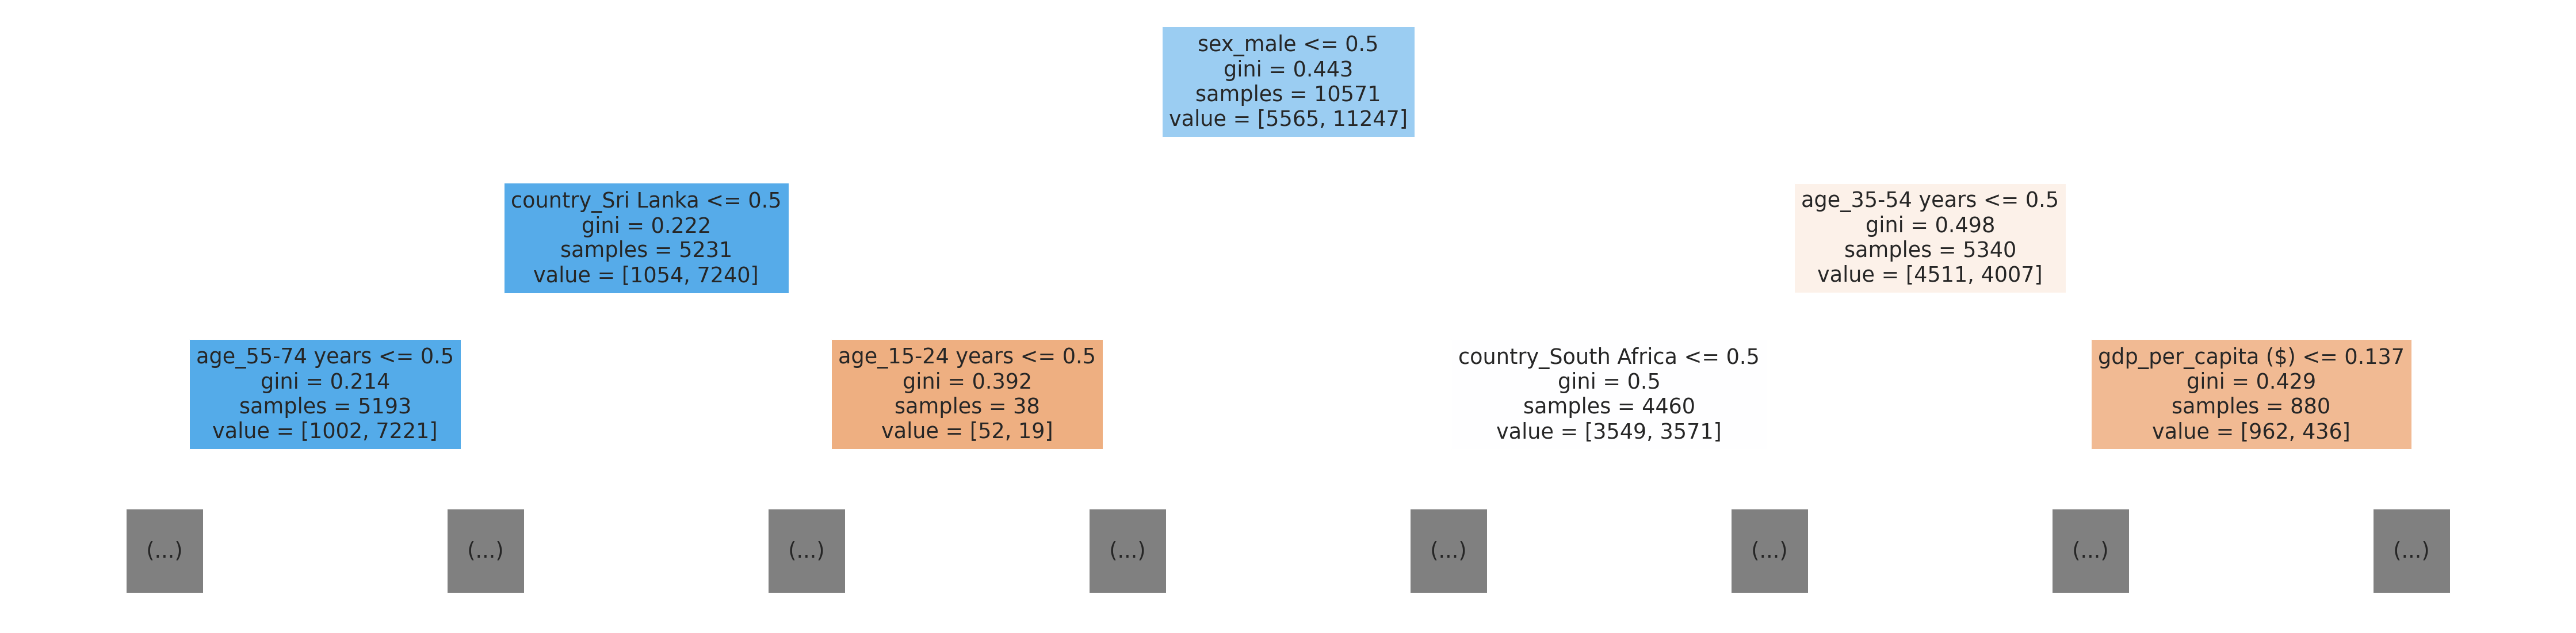

In [79]:
plt.figure(figsize=(80, 20))
plot_tree(rf.estimators_[0], feature_names=X_train.columns, max_depth=2, filled=True);

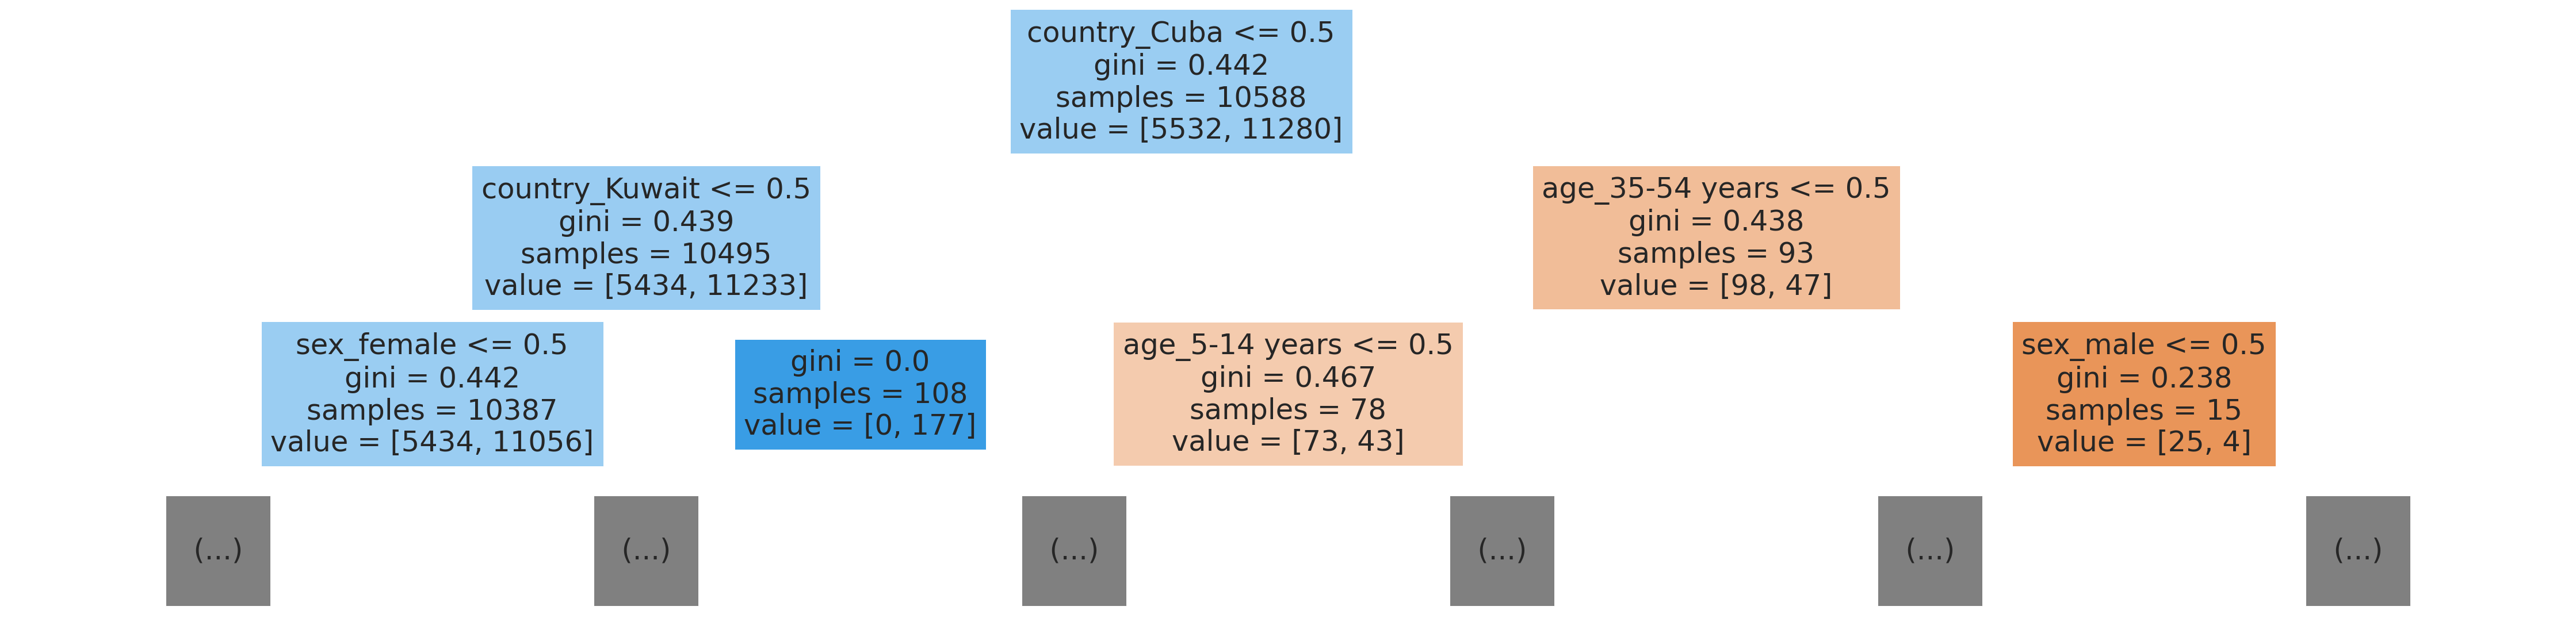

In [80]:
plt.figure(figsize=(80, 20))
plot_tree(rf.estimators_[1], feature_names=X_train.columns, max_depth=2, filled=True);

We can see that each decision tree is using different features to split the samples. This is because the dataset was built from various sub-samples of the dataset (attribute `bootstrap` was set as `True` by default). This "randomness" helps control overfitting. 

## Hyperparameter tuning

Let's try to tune a few important hyperparameters for random forest and see if we can further improve the model accuracy. Here, we look at:

1. `n_estimators`: number of trees in the forest
2. `max_features`: number of features to consider when looking for the best split

We'll evaluate a combination of these two hyperparameters and see which combination yields the best prediction. To do this, let's first define a helper function.

In [81]:
def train_and_evaluate(X_train, train_target, X_val, val_target, **params):
    rf = RandomForestClassifier(n_jobs=-1, random_state=1, **params)
    rf.fit(X_train, train_target)
    train_pred = rf.predict(X_train)
    val_pred = rf.predict(X_val)
    train_error = 1 - accuracy_score(train_target, train_pred)
    val_error = 1 - accuracy_score(val_target, val_pred)
    return {'model': rf, **params, 'train_error': train_error, 'val_error': val_error}

Let's evaluate the random forest model using `n_estimators` of (10, 100, 500) and `max_features` of (sqrt, log2). We will compile the training errors and validation errors and use them to select the optimal model.

In [82]:
errors_list = []

for n_estimators in [10, 100, 500]:
    for max_features in ['sqrt', 'log2']:
        outcome = train_and_evaluate(X_train, train_target, X_val, val_target, n_estimators=n_estimators, max_features=max_features)
        errors_list.append(outcome)

Let's convert the `errors_list` (list of dictionary) into a Pandas dataframe and sort by validation error.

In [83]:
errors_df = pd.DataFrame(errors_list).sort_values(by='val_error')
errors_df

,model,n_estimators,max_features,train_error,val_error
5,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",500,log2,0.000000,0.092199
3,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",100,log2,0.000059,0.095583
2,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",100,sqrt,0.000059,0.097679
4,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",500,sqrt,0.000000,0.097840
1,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",10,log2,0.004996,0.108640
0,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",10,sqrt,0.004937,0.109284


Model #5 is giving the highest validation accuracy (~ 90.8%). This is slightly higher than the validation accuracy (~90.2%) before tuning the hyperparameters. Let's evaluate the test set accuracy using this model.

In [84]:
selected_rf = errors_df.iloc[5]['model']

In [85]:
test_pred = selected_rf.predict(X_test)
accuracy_score(test_target, test_pred)

0.8786427976686095

The test set accuracy is 87.9% (lower than the validation accuracy).

## Save Trained Model

Let's save the random forest model using `joblib`.


In [86]:
suicide_risk_rf = {
    'model': selected_rf,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [87]:
joblib.dump(suicide_risk_rf, 'suicide_risk_rf.joblib')

['suicide_risk_rf.joblib']

## Make Predictions Based on New Inputs

Let's load the random forest model from `joblib` object.

In [88]:
suicide_risk_rf_clf = joblib.load('suicide_risk_rf.joblib')

We can use the `predict_input` function, which was defined in the 'Decision Tree' section to make predictions based on new inputs.

In [89]:
new_input = {
    'country': 'Albania',
    'year': 2020,
    'sex': 'female',
    'age': '15-24 years',
    'suicides_no': 10,
    'population': 250000,
    'suicides/100k pop': 4,
    'HDI for year': 0.75,
    'gdp_for_year ($)': '11,000,000,000',
    'gdp_per_capita ($)': 4400,
    'generation': 'Millenials' 
}

In [90]:
predict_input(suicide_risk_rf_clf, new_input)

('low', 1.0)

# Compare Decision Tree and Random Forest Model Using AUC-ROC Curve

AUC (Area Under the Curve) - ROC (Receiver Operating Characteristics) curve measures the model performance for the classification problem at various threshold settings by summarizing the trade-off between the true positive rate (TPR) and false positive rate (FPR).

![](https://upload.wikimedia.org/wikipedia/commons/3/36/Roc-draft-xkcd-style.svg)

<center><i>Image source: Wikipedia </i></center>

ROC is a probability curve. AUC represents the degree of separability. The higher the AUC, the better the model is at predicting 0 class as 0 and 1 class as 1. 

*   AUC near to 1: excellent model with good measure of separability
*   AUC = 0.5: model with no class separation capacity (=making random guesses)
*   AUC near to 0: perfectly incorrect model with worst measure of separability

Let's compare the performance of our decision tree and random forest model using AUC-ROC curve. First, we need to calculate the predicted probabilities of the 1 class (=low suicide risk).



In [92]:
dt_probs = suicide_risk_dt_clf['model'].predict_proba(X_test)
rf_probs = suicide_risk_rf_clf['model'].predict_proba(X_test)

# Keep probabilities for positive outcome only
dt_probs = dt_probs[:, 1]
rf_probs = rf_probs[:, 1]

Let's calculate the AUROC of both models.

In [93]:
from sklearn.metrics import roc_curve, roc_auc_score

# The probability estimates correspond to the probability of the class with the greater label, i.e. estimator.classes_[1] -> 'low' suicide risk
dt_auc = roc_auc_score(test_target, dt_probs)
rf_auc = roc_auc_score(test_target, rf_probs)

print('Decision Tree (AUROC): {:.3f}'.format(dt_auc))
print('Random Forest (AUROC): {:.3f}'.format(rf_auc))

Decision Tree (AUROC): 0.916
Random Forest (AUROC): 0.943


Random forest model has a better separation capacity (AUROC = 0.943) than the decision tree model (AUROC = 0.916). Let's also plot the ROC curve of both models.

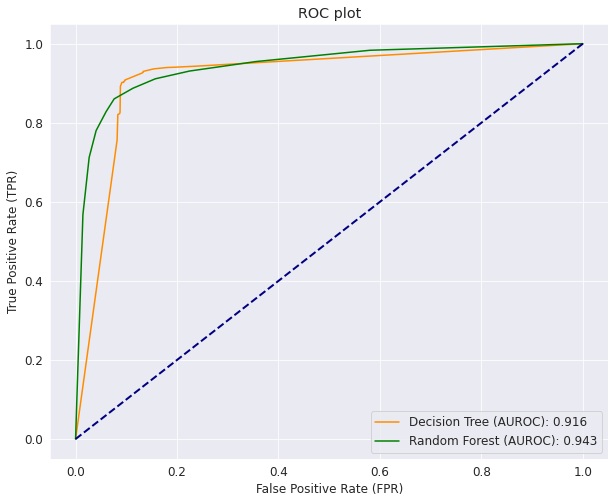

In [94]:
# Compute ROC curves for both models
dt_fpr, dt_tpr, dt_t = roc_curve(test_target, dt_probs, pos_label='low')
rf_fpr, rf_tpr, rf_t = roc_curve(test_target, rf_probs, pos_label='low')

# Plot ROC curves
plt.plot(dt_fpr, dt_tpr, color='darkorange', label='Decision Tree (AUROC): {:.3f}'.format(dt_auc))
plt.plot(rf_fpr, rf_tpr, color='green', label='Random Forest (AUROC): {:.3f}'.format(rf_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC plot')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show();

## Tune Optimal Threshold for the Model

By default, in a binary classification problem, `scikit-learn` uses the threshold of 0.5 for classification. For example, if the predicted probability is >=0.5, the sample is predicted to be class 1. However, the optimal threshold for separation might not always be 0.5. 

Let's try to locate the optimal threshold with the optimal balance between TPR and FPR using a method called '[Youden's J Statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic)'.

In essence, J statistic = sensitivity + specificity - 1 = true positive rate - false positive rate.

In [95]:
# Get the best threshold for random forest model
J_rf = rf_tpr - rf_fpr
ix = np.argmax(J_rf)
best_thresh = rf_t[ix]
print('Best Threshold for random forest: %f' % (best_thresh))

# Get the best threshold for decision tree model
J_dt = dt_tpr - dt_fpr
ix = np.argmax(J_dt)
best_thresh = dt_t[ix]
print('Best Threshold for decision tree: %f' % (best_thresh))

Best Threshold for random forest: 0.600000
Best Threshold for decision tree: 0.666667


We can use the best threshold (instead of the default threshold of 0.5) to tune our models and see if the model accuracy improves.

To do this, we need to "manually" create the predicted test outcomes by checking if the probabilities of positive outcome are larger than the defined threshold.

In [98]:
# Set the prediction to 'low' if probability estimate of positive outcome (low suicide risk) > threshold
rf_test_pred = np.where(rf_probs >= 0.600, 'low', 'high')
print('Test accuracy (random forest) (threshold = 0.600): ', accuracy_score(test_target, rf_test_pred))
print('Test accuracy (random forest) (default threshold): ', accuracy_score(test_target, suicide_risk_rf_clf['model'].predict(X_test)), '\n')

dt_test_pred = np.where(dt_probs >= 0.666667, 'low', 'high')
print('Test accuracy (decision tree) (threshold = 0.667): ', accuracy_score(test_target, dt_test_pred))
print('Test accuracy (decision tree) (default threshold): ', accuracy_score(test_target, suicide_risk_dt_clf['model'].predict(X_test)))


Test accuracy (random forest) (threshold = 0.600):  0.8786427976686095
Test accuracy (random forest) (default threshold):  0.8786427976686095 

Test accuracy (decision tree) (threshold = 0.667):  0.9057035803497085
Test accuracy (decision tree) (default threshold):  0.9094504579517069


There is no much difference in the test accuracy of both models before *vs.* after we tune the threshold.

Instead of using ROC curve to find the optimal threshold, we can use another curve, called precision-recall curve, which is recommended when there is an imbalance in the obversations between two classes. In our dataset, we have approx. 2x more data of low suicide risk class than high suicide risk class.

```
raw_df['suicide_risk'].value_counts()

> low     19061
> high     8759
```

The principle is similar to the ROC-AUC curve - more information can be found [here](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

# Conclusion & Next Steps

We've successfully trained a decision tree and a random forest model to predict the suicide risk based on factors such as age group, gender, HDI per year (composite index of life expectancy, education, and per capita income), GDP per capita and country.

It is important to recall that we do not have suicide data for most Asian and African countries in our training dataset. Hence, the ML models shall not be generalized beyond the countries available in our dataset. 

Here are a few next steps we might take to better make predictions / generalize our model:

* Collect data from more Asia and Africa countries
* Obtain additional features such as employment status, financial situation (debt), any chronic health issues, country's mental health infrastructure, etc.

It's very difficult to obtain all the data for all the countries across the globe. We can also zoom into a particular country and collect / analyze the features more comprehensively. This might help us design targeted suicide prevention strategies for the higher-suicide risk group (e.g., include mental health education in secondary school, organize more community events for elderly, etc.).

# References

Here are some useful references:

*   [Hyperparameter tuning for classification ML algorithms](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)
*   [Tuning a decision tree](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)
*   [ROC Curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Threshold moving for imbalanced classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)
*   WHO suicide [fact sheet](https://www.who.int/news-room/fact-sheets/detail/suicide)
